# Libraries

In [223]:
import numpy as np
import matplotlib.pyplot as plt

# Material Properties

In [224]:
elastic_modulus = 1e9
v = 0.3

# Quadrature Points

In [225]:
quad_points = np.array([[1/np.sqrt(3), 1/np.sqrt(3)], [-1/np.sqrt(3), 1/np.sqrt(3)], 
                        [-1/np.sqrt(3), -1/np.sqrt(3)], [1/np.sqrt(3), -1/np.sqrt(3)]])
w = np.array([1,1,1,1])

# Shape Functions

In [226]:
def evaluate_N(xi, eta):
    n = np.zeros(4)
    n[0] = (1+xi)*(1+eta)/4
    n[1] = (1-xi)*(1+eta)/4
    n[2] = (1-xi)*(1-eta)/4
    n[3] = (1+xi)*(1-eta)/4
    return n

def evaluate_dN_d_xi(xi, eta):
    v = np.zeros(4)
    v[0] = (1+eta)/4
    v[1] = (-1-eta)/4
    v[2] = (-1+eta)/4
    v[3] = (1-eta)/4
    return v

def evaluate_dN_d_eta(xi, eta):
    v = np.zeros(4)
    v[0] = (1+xi)/4
    v[1] = (1-xi)/4
    v[2] = (-1+xi)/4
    v[3] = (-1-xi)/4
    return v

In [227]:
#evaluate shape functions and derivatives at quadrature points once and save them in memory to decrease runtime
n_quad = len(quad_points)
N = np.zeros([n_quad, 4])
dN_d_xi = np.zeros([n_quad, 4])
dN_d_eta = np.zeros([n_quad, 4])
for i in range(n_quad):
    xi = quad_points[i,0]
    eta = quad_points[i,1]
    N[i] = evaluate_N(xi,eta)
    dN_d_xi[i] = evaluate_dN_d_xi(xi,eta)
    dN_d_eta[i] = evaluate_dN_d_eta(xi,eta)

print(N)

[[0.62200847 0.16666667 0.0446582  0.16666667]
 [0.16666667 0.62200847 0.16666667 0.0446582 ]
 [0.0446582  0.16666667 0.62200847 0.16666667]
 [0.16666667 0.0446582  0.16666667 0.62200847]]


# Node Class

In [228]:
class Node:
    def __init__(self, id, x, y):
        self.id = id
        self.x  = x
        self.y  = y
    
    def __repr__(self):
        return f"Node({self.id}, x={self.x}, y={self.y})"

# Element Class

In [229]:
class Element:
    def __init__(self, id, nodes):
        self.id = id
        self.nodes = nodes

    def __repr__(self):
        node_ids = [node.id for node in self.nodes]  
        return f"Element(id={self.id}, nodes={node_ids})"
    
    def coordinates(self):
        return np.array([(node.x, node.y) for node in self.nodes])
    
    def compute_E(self):
        E = np.zeros([3,3])
        E[0,0] = 1-v
        E[0,1] = v
        E[0,2] = 0
        E[1,0] = v
        E[1,1] = 1-v
        E[0,2] = 0
        E[2,0] = 0
        E[2,1] = 0
        E[2,2] = (1-2*v)/2
        E = E * elastic_modulus / ((1+v)*(1-2*v))
        return E

    def compute_J(self, i_quad):
        #define jacobian matrix at quadrature point i, j
        j = np.zeros([2,2])
        #get coordinates of the nodes 
        coords = self.coordinates()
        x = coords[:,0]
        y = coords[:,1]
        #compute jacobian matrix elements
        j[0,0] = np.dot(x, dN_d_xi[i_quad])
        j[0,1] = np.dot(y, dN_d_xi[i_quad])
        j[1,0] = np.dot(x, dN_d_eta[i_quad])
        j[1,1] = np.dot(y, dN_d_eta[i_quad])
        return j

    def compute_B(self, i_quad, J_inv):
        dN = np.zeros([4,2]) #derivative matrix, size = n_shape * n_dims
        for i in range(4): #loop over shape functions
            mat = np.array([dN_d_xi[i_quad,i], dN_d_eta[i_quad,i]])
            dN[i] = np.matmul(J_inv, mat)
        B = np.zeros([3,8])
        B[0,0] = dN[0,0]
        B[0,2] = dN[1,0]
        B[0,4] = dN[2,0]
        B[0,6] = dN[3,0]
        B[1,1] = dN[0,1]
        B[1,3] = dN[1,1]
        B[1,5] = dN[2,1]
        B[1,7] = dN[3,1]
        B[2,0] = dN[0,1]
        B[2,1] = dN[0,0]
        B[2,2] = dN[1,1]
        B[2,3] = dN[1,0]
        B[2,4] = dN[2,1]
        B[2,5] = dN[2,0]
        B[2,6] = dN[3,1]
        B[2,7] = dN[3,0]
        return B
    
    def localStiffnessMatrix(self):
        k = 0
        E = self.compute_E()
        for i in range(n_quad):
            J = self.compute_J(i)
            J_inv = np.linalg.inv(J)
            det_J = np.linalg.det(J)
            B = self.compute_B(i, J_inv)
            BT = np.transpose(B)
            k += BT @ E @ B * det_J * w[i]
        return k
    
    def compute_stresses(self, D):
        stress = np.zeros([n_quad, 3])
        # Loop over the quadrature points
        for i in range(n_quad):
            J = self.compute_J(i)
            J_inv = np.linalg.inv(J)
            B = self.compute_B(i, J_inv)
            # Get the displacements for the element (use D with the corresponding DOFs)
            d = np.array([item for pair in zip([D[2 * (node.id - 1)] for node in self.nodes], [D[2 * (node.id - 1) + 1] for node in self.nodes]) 
                          for item in pair])
            # Calculate the strain vector
            strain = B @ d
            # Compute the stress vector
            E = self.compute_E()  
            stress[i,:] = E @ strain
        return stress  

# Mesh class

In [230]:
class Mesh:
    def read_node_list(self, file_path):
        nodes = []
        node_section = False  # Flag to check if we are in the *Node section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Node section
                if line.startswith('*Node'):
                    node_section = True
                    continue  # Skip the line that contains *Node header
                # Start of element section, stop reading node
                if node_section and line.startswith('*Element'): 
                    node_section = False
                    break
                # Skip the line if it is not a node data line
                if not line or line.startswith('*') or not line[0].isdigit():
                    continue
                # If we are in the *Node section, process the node data
                node_data = line.split(',')
                node_id = int(node_data[0].strip())
                x = float(node_data[1].strip())
                y = float(node_data[2].strip())
                # Create Node object and append to the list
                node = Node(node_id, x, y)
                nodes.append(node)
        return nodes
    
    def read_element_list(self, file_path):
        elements = []
        element_section = False  # Flag to check if we are in the *Element section
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                # Check for the start of the *Element section
                if line.startswith('*Element'):
                    element_section = True
                    continue  # Skip the line that contains *Element header
                # Stop reading elements
                if element_section and line.startswith('*Nset'): 
                    element_section = False
                    break
                # Skip the line if it is not an element data line
                if not line or line.startswith('*') or not line[0].isdigit() or not element_section:
                    continue
                # If we are in the *Element section, process the element data
                element_data = line.split(',')
                element_id = int(element_data[0].strip())
                nodes = []
                for i in range(1,5):
                    node_id = int(element_data[i].strip())
                    node_index = node_id - 1 #zero indexing shift
                    nodes.append(self.nodes[node_index]) 
                # Create Element object and append to the list
                element = Element(element_id, nodes)
                elements.append(element)
        return elements
    
    def __init__(self, file_path):
        self.nodes = self.read_node_list(file_path)
        self.elements = self.read_element_list(file_path)
    
    def plot_mesh(mesh):
        plt.figure(figsize=(8, 6))
        # Plot each element
        for element in mesh.elements:
            # Get the coordinates of the nodes
            coords = np.array([(node.x, node.y) for node in element.nodes])
            # Close the polygon by appending the first node again
            coords = np.vstack([coords, coords[0]])
            plt.plot(coords[:, 0], coords[:, 1], marker='o')
        # Set labels and title
        plt.title('Finite Element Mesh')
        plt.xlabel('x(m)')
        plt.ylabel('y(m)')
        plt.axis('equal')
        plt.grid(True)
        plt.show()

# Mesh Generation

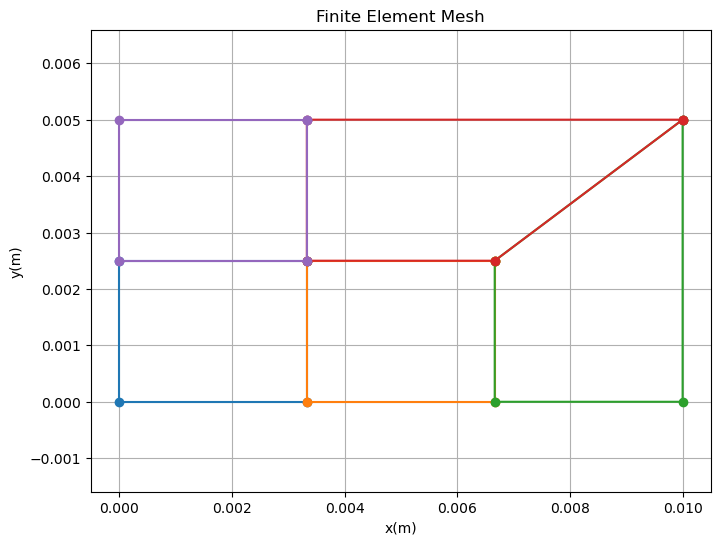

In [231]:
file_path = 'input.inp'  
mesh = Mesh(file_path)
mesh.plot_mesh()

# Assembly

In [232]:
n_nodes = len(mesh.nodes)
#Global stiffness matrix and global load vector
K_global = np.zeros((2*n_nodes, 2*n_nodes))
N_local_nodes = 4
#loop over all elements
for element in mesh.elements:
    k_local = element.localStiffnessMatrix()
    local_indices = [node.id - 1 for node in element.nodes] #adjust for zero indexing of global matrix
    local_indices = np.multiply(2,local_indices) 
    local_indices = np.concatenate([np.arange(x, x+2) for x in local_indices]) #expand the indices for 2 dof
    for i in range(2*N_local_nodes):
        for j in range(2*N_local_nodes):
            K_global[local_indices[i], local_indices[j]] += k_local[i,j]

# Load

In [233]:
R_global = np.zeros(2*n_nodes)
R_global[6] = 18
R_global[8] = 42
R_global[9] = 333.0
R_global[17] = 166.5
R_global[19] = 499.5

# Boundary Conditions

In [234]:
i_zero_displacement = [0, 1, 3, 5, 7, 14, 16]
ids = np.arange(0,20,1)
mask = np.setdiff1d(ids, i_zero_displacement)

# Solve 

In [235]:
K_reduced = np.delete(K_global, i_zero_displacement, 0)
K_reduced = np.delete(K_reduced, i_zero_displacement, 1)
R_reduced = np.delete(R_global, i_zero_displacement)
D_reduced = np.linalg.solve(K_reduced,R_reduced)
D = np.zeros(2*n_nodes) #full displacement vector
D[mask] = D_reduced
R = K_global @ D - R_global #reaction forces
R[abs(R)<1.0e-10] = 0
thickness = 0.005
D = D/thickness

# Output

In [236]:
#Displacements
print(f"{'Node ID':<10} {'u_magnitude (m)':<20} {'u_x (m)':<15} {'u_y (m)':<15}")
print("-" * 60)
for i in range(n_nodes):
    j = 2*i    
    k = 2*i+1  
    u_x = f"{D[j]:.3g}" 
    u_y = f"{D[k]:.3g}"
    u_m = np.sqrt(D[j]**2 + D[k]**2)
    u_m_str = f"{u_m:.3g}"
    print(f"{i+1:<10} {u_m_str:<20} {u_x:<15} {u_y:<15}")
print('-' * 60)

Node ID    u_magnitude (m)      u_x (m)         u_y (m)        
------------------------------------------------------------
1          0                    0               0              
2          1.93e-05             -1.93e-05       0              
3          3.96e-05             -3.96e-05       0              
4          6.13e-05             -6.13e-05       0              
5          9.91e-05             -5.09e-05       8.5e-05        
6          5.77e-05             -3.78e-05       4.37e-05       
7          4.78e-05             -1.88e-05       4.39e-05       
8          4.34e-05             0               4.34e-05       
9          8.67e-05             0               8.67e-05       
10         8.9e-05              -1.85e-05       8.71e-05       
------------------------------------------------------------


In [237]:
#Reaction forces
print(f"{'Node ID':<10} {'R_Magnitude (N)':<20} {'R_x (N)':<15} {'R_y (N)':<15}")
print("-" * 60)
for i in range(n_nodes):
    j = 2*i    
    k = 2*i+1  
    R_x = f"{R[j]:.3g}" 
    R_y = f"{R[k]:.3g}"
    R_m = np.sqrt(R[j]**2 + R[k]**2)
    R_m_str = f"{R_m:.3g}"
    print(f"{i+1:<10} {R_m_str:<20} {R_x:<15} {R_y:<15}")
print("-" * 60)

Node ID    R_Magnitude (N)      R_x (N)         R_y (N)        
------------------------------------------------------------
1          169                  -15.1           -168           
2          338                  0               -338           
3          337                  0               -337           
4          156                  0               -156           
5          0                    0               0              
6          0                    0               0              
7          0                    0               0              
8          30.2                 -30.2           0              
9          14.7                 -14.7           0              
10         0                    0               0              
------------------------------------------------------------


In [238]:
#Stresses
print(f"{'Element ID':<15} {'Quad Point':<15} {'S11 (Pa)':<14} {'S22 (Pa)':<15}")
print("-" * 60)
# Loop over each element
for element in mesh.elements:
    stress = element.compute_stresses(D)  
    # Loop over each quadrature point 
    for quad_id in range(stress.shape[0]):
        S11 = stress[quad_id, 0]
        S22 = stress[quad_id, 1]
        print(f"{element.id:<15} {quad_id+1:<15} {S11:.2e} {'':<5} {S22:.2e}")
print("-" * 60)

Element ID      Quad Point      S11 (Pa)       S22 (Pa)       
------------------------------------------------------------
1               1               2.47e+06       2.03e+07
1               2               2.39e+06       2.02e+07
1               3               2.29e+06       2.01e+07
1               4               2.36e+06       2.03e+07
2               1               2.32e+06       2.02e+07
2               2               2.35e+06       2.03e+07
2               3               2.04e+06       2.02e+07
2               4               2.00e+06       2.01e+07
3               1               2.27e+06       1.97e+07
3               2               3.00e+06       2.03e+07
3               3               1.67e+06       1.97e+07
3               4               1.37e+06       1.93e+07
4               1               3.13e+06       2.00e+07
4               2               3.24e+06       2.03e+07
4               3               2.62e+06       2.00e+07
4               4               2.45